In [19]:
# Dependencies
import networkx as nx
import matplotlib.pyplot as plt


In [20]:
# Classes
class State():
    def __init__(self,name):
        self.name = name
        self.final = False
        self.edges = []

    def add_edge(self, destiny, transition, output):
        edge = Edge(self.name, destiny, transition, output)
        self.edges.append(edge)

    def add_state_to_fst(self, fst):
        fst.add_node(self.name,final = self.final)
    
    def add_edges_to_fst(self,fst):
        for edge in self.edges:
            fst.add_edge(edge.origin, edge.destiny,transition = edge.transition, output = edge.output)
    
    def set_final(self):
        self.final = True

class Edge():
    def __init__(self, origin, destiny, transition, output):
        self.origin = origin
        self.destiny = destiny
        self.transition = transition
        self.output = output

In [21]:
# Utils
def findMinimizedState():
    pass

In [22]:
# Create Minimal Transducer
def create_minimal_transducer(dictionary):
    fst = nx.DiGraph()
    minimal_states = []
    state0 = State(0)
    state0.add_edge(1,'a',1)
    state0.add_edge(2,'b',3)
    state1 = State(1)
    state1.add_edge(2,'b',4)
    state2 = State(2)
    state2.set_final()

    minimal_states.append(state0)
    minimal_states.append(state1)
    minimal_states.append(state2) 

    for state in minimal_states:
        state.add_state_to_fst(fst)
    for state in minimal_states:
        state.add_edges_to_fst(fst)

    return fst

In [23]:
# Create Dictionary
def create_dictionary():
    dictionary = {"jan": 1, "feb": 2, "mar": 3, "apr": 4, "may": 5, "jun": 6,
                  "jul": 7, "aug": 8, "sep": 9, "oct": 10, "nov": 11, "dec": 12}
    dictionary = dict(sorted(dictionary.items()))
    return dictionary


In [24]:
# Read Input

def read_input(input, fst):
    state = 0
    output = 0
    for letter in input:
        current_state_edges = dict(fst[state])
        prev_state = state
        for next_state, edge_properties in current_state_edges.items():
            if edge_properties['transition'] == letter:
                state = next_state
                output += edge_properties['output']
                break
        if (state == prev_state):
            break
    return output


1


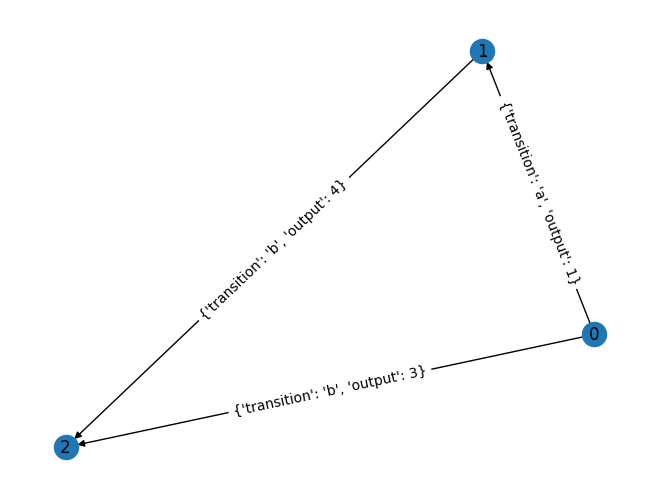

In [25]:
# Main

dictionary = create_dictionary()
fst = create_minimal_transducer(dictionary)
pos = nx.spring_layout(fst)
plt.figure()
nx.draw(fst, pos, with_labels=True)
nx.draw_networkx_edge_labels(fst, pos)

print(read_input("aaa", fst))
